# 필요한 라이브러리 설정

In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=7fbee1865a349705e04107ab0de48941a68decd498987c2578be2ec70f7ac10e
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
from chart_studio import plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-whitegrid')
print(cf.__version__)

# 맥북에서 레티나 설정
%config InlineBackend.figure_format = 'retina'
cf.go_offline()

0.17.3


# 데이터 시각화
## 날짜별 수요 분석
### 1월 전체 trip 수

In [ ]:
%%time
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id='newyorktaxi-340407', auth_local_webserver=False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=fFivNV10sBkTdOO948HO1RaY63wUFR&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWg8kER43QtTY3LLvb_brOrpNQItHrk0p7V3uU11QhK01er1-QgrJjw
CPU times: user 418 ms, sys: 70.8 ms, total: 489 ms
Wall time: 19.5 s


In [ ]:
df.head(10)

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081
5,2015-01-01 05:00:00,9112
6,2015-01-01 06:00:00,6637
7,2015-01-01 07:00:00,6011
8,2015-01-01 08:00:00,5586
9,2015-01-01 09:00:00,6977


In [ ]:
df = df.set_index('pickup_hour')
df.head(10)

,cnt
pickup_hour,
2015-01-01 00:00:00,28312
2015-01-01 01:00:00,31707
2015-01-01 02:00:00,28068
2015-01-01 03:00:00,24288
2015-01-01 04:00:00,17081
2015-01-01 05:00:00,9112
2015-01-01 06:00:00,6637
2015-01-01 07:00:00,6011
2015-01-01 08:00:00,5586


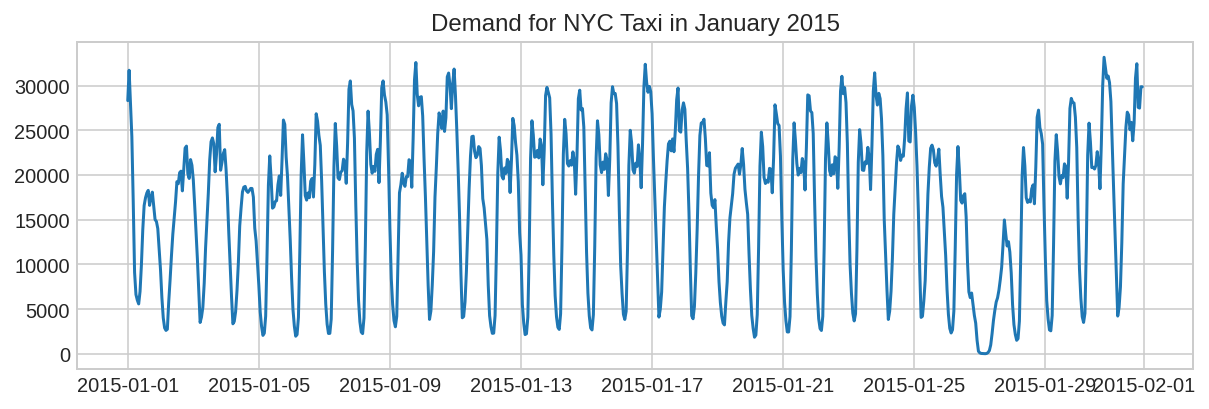

In [ ]:
plt.figure(figsize=(10, 3))
plt.title('Demand for NYC Taxi in January 2015')
plt.plot(df)
plt.show()

## 1월 동안 날짜별 trip 수

In [ ]:
df['date'] = df.index.date

In [ ]:
df.head(10)

,cnt,date
pickup_hour,,
2015-01-01 00:00:00,28312,2015-01-01
2015-01-01 01:00:00,31707,2015-01-01
2015-01-01 02:00:00,28068,2015-01-01
2015-01-01 03:00:00,24288,2015-01-01
2015-01-01 04:00:00,17081,2015-01-01
2015-01-01 05:00:00,9112,2015-01-01
2015-01-01 06:00:00,6637,2015-01-01
2015-01-01 07:00:00,6011,2015-01-01
2015-01-01 08:00:00,5586,2015-01-01


In [ ]:
df = df.groupby(['date'])[['cnt']].sum()
df.head(10)

,cnt
date,
2015-01-01,382014
2015-01-02,345296
2015-01-03,406769
2015-01-04,328848
2015-01-05,363454
2015-01-06,384324
2015-01-07,429653
2015-01-08,450920
2015-01-09,447947


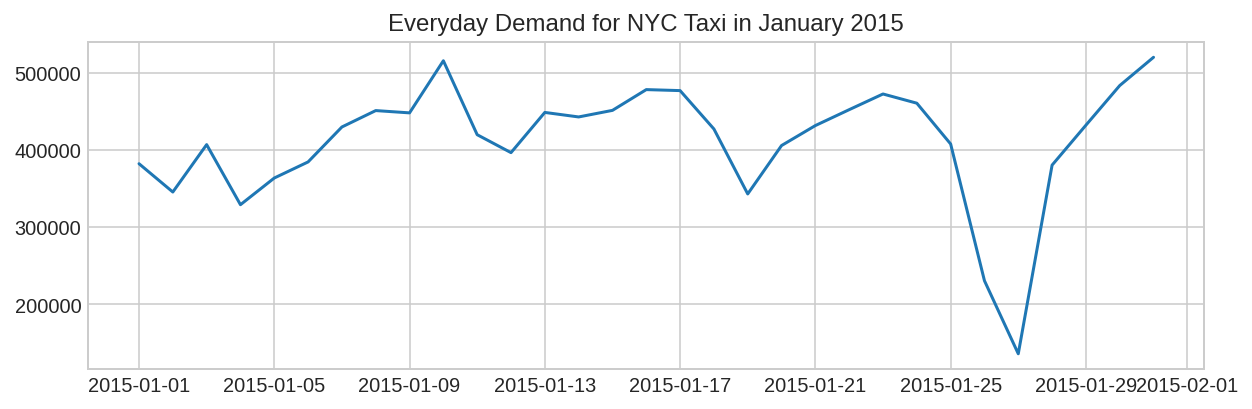

In [ ]:
plt.figure(figsize=(10, 3))
plt.title('Everyday Demand for NYC Taxi in January 2015')
plt.plot(df)
plt.show()

## 지역별 수요 분석
- 각 지역별 위치 정보를 가져오기 위해서 `bigquery-public-data.geo_us_boundaries.zip_codes`를 사용한다.

In [ ]:
query = """ 
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""
df = pd.read_gbq(query=query, dialect='standard', project_id='newyorktaxi-340407')

In [ ]:
df.head(5)

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,11371,New York city,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",2015-01-01,76
1,10017,New York city,"POLYGON((-73.981372 40.752814, -73.981822 40.7...",2015-01-01,707
2,11749,"Hauppauge CDP, Islandia village, Central Islip...","MULTIPOLYGON(((-73.196558 40.806279, -73.19748...",2015-01-01,2
3,11203,New York city,"POLYGON((-73.947676 40.660297, -73.947653 40.6...",2015-01-01,3
4,11419,New York city,"POLYGON((-73.837511 40.691297, -73.837459 40.6...",2015-01-01,3


### 트립이 가장 많은 지역구 찾기

In [ ]:
df_zip = df.groupby(['zip_code', 'zip_code_geom'])['cnt'].sum().reset_index()
df_zip.head(5)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454


In [ ]:
df_zip['cnt'].sum()

12322300

In [ ]:
# cnt/총 합으로 그 지역의 택시 수요 비율을 구한다.
df_zip['proportion'] = (df_zip['cnt']/df_zip['cnt'].sum()).round(3)
df_zip.head(5)

,zip_code,zip_code_geom,cnt,proportion
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004


In [ ]:
# 비율이 너무 낮은 값은 제거한다.
df_zip.tail(10)

,zip_code,zip_code_geom,cnt,proportion
364,12601,"MULTIPOLYGON(((-73.919145 41.677197, -73.91913...",1,0.0
365,12729,"POLYGON((-74.673656 41.496556, -74.697836 41.4...",1,0.0
366,12771,"POLYGON((-74.726018 41.396123, -74.726008 41.3...",1,0.0
367,13029,"POLYGON((-76.212177 43.241684, -76.213393 43.2...",1,0.0
368,13118,"POLYGON((-76.543327 42.783988, -76.543272 42.7...",1,0.0
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [ ]:
idx = df_zip[df_zip['proportion']==0].index
df_zip = df_zip.drop(idx)
df_zip.tail(10)

,zip_code,zip_code_geom,cnt,proportion
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
200,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",61907,0.005
204,11215,"POLYGON((-74.000995 40.654067, -74.002144 40.6...",12420,0.001
206,11217,"POLYGON((-73.990424 40.682694, -73.990867 40.6...",22778,0.002
211,11222,"POLYGON((-73.962672 40.736446, -73.962668 40.7...",13370,0.001
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001
273,11430,"POLYGON((-73.832705 40.665406, -73.831781 40.6...",233390,0.019


In [ ]:
df_zip.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,proportion
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [ ]:
df_zip.to_csv('zip_code_proportion.csv', index=False)

### 시간대에 따른 각 지역별 수요 분석

In [ ]:
df['hour'] = df['pickup_hour'].dt.hour
df.head(5)

,zip_code,city,zip_code_geom,pickup_hour,cnt,hour
0,11371,New York city,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",2015-01-01,76,0
1,10017,New York city,"POLYGON((-73.981372 40.752814, -73.981822 40.7...",2015-01-01,707,0
2,11749,"Hauppauge CDP, Islandia village, Central Islip...","MULTIPOLYGON(((-73.196558 40.806279, -73.19748...",2015-01-01,2,0
3,11203,New York city,"POLYGON((-73.947676 40.660297, -73.947653 40.6...",2015-01-01,3,0
4,11419,New York city,"POLYGON((-73.837511 40.691297, -73.837459 40.6...",2015-01-01,3,0


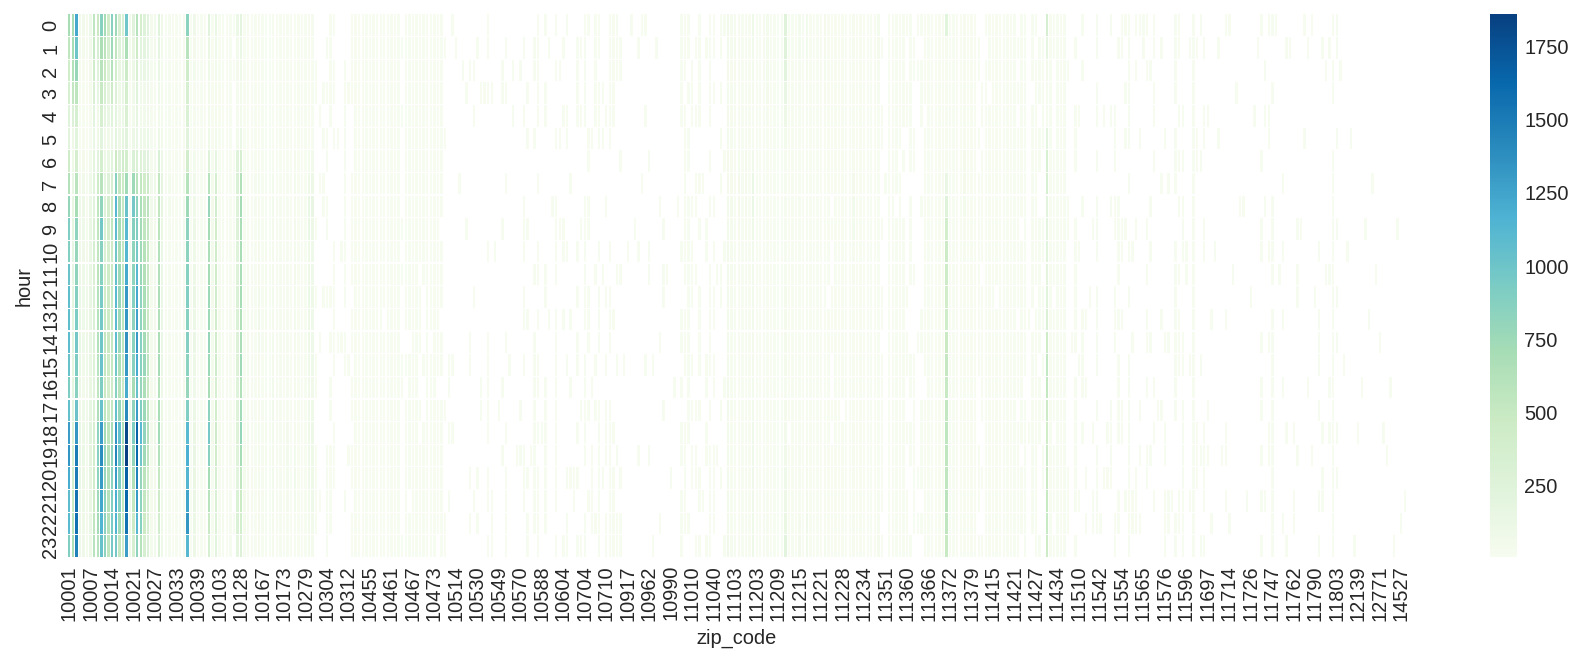

In [ ]:
plt.figure(figsize=(15,5))
sns.heatmap(df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.1, cmap='GnBu');

In [ ]:
df_hour_zip = df.pivot_table('cnt', index='zip_code', columns='hour', aggfunc='mean')
df_hour_zip

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,702.032258,543.033333,415.483871,336.133333,254.766667,213.566667,449.967742,632.096774,796.548387,911.677419,...,1083.129032,1019.935484,916.806452,1051.258065,1287.935484,1341.806452,1201.161290,1082.677419,1101.612903,896.096774
10002,705.000000,701.516129,628.774194,526.633333,279.677419,98.032258,91.677419,126.806452,158.774194,170.225806,...,192.741935,186.516129,169.516129,209.774194,272.129032,319.354839,371.806452,467.354839,561.741935,653.096774
10003,1223.290323,1001.483871,782.548387,562.967742,348.566667,223.433333,377.000000,583.935484,700.483871,819.290323,...,971.419355,930.645161,855.967742,1011.548387,1334.709677,1495.032258,1494.032258,1555.064516,1576.870968,1466.290323
10004,59.866667,40.500000,26.533333,16.032258,12.466667,11.833333,26.500000,49.483871,88.225806,79.677419,...,124.806452,113.290323,96.064516,104.774194,123.903226,129.193548,120.806452,115.129032,99.870968,82.900000
10005,55.033333,34.600000,22.933333,13.900000,14.733333,18.800000,49.566667,72.645161,96.096774,83.129032,...,82.354839,73.258065,62.967742,84.709677,108.709677,116.258065,109.774194,105.838710,92.548387,73.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
14072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_hour_zip['mean'] = df_hour_zip.mean(axis=1)
df_hour_zip

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,702.032258,543.033333,415.483871,336.133333,254.766667,213.566667,449.967742,632.096774,796.548387,911.677419,...,1019.935484,916.806452,1051.258065,1287.935484,1341.806452,1201.161290,1082.677419,1101.612903,896.096774,845.309812
10002,705.000000,701.516129,628.774194,526.633333,279.677419,98.032258,91.677419,126.806452,158.774194,170.225806,...,186.516129,169.516129,209.774194,272.129032,319.354839,371.806452,467.354839,561.741935,653.096774,315.932303
10003,1223.290323,1001.483871,782.548387,562.967742,348.566667,223.433333,377.000000,583.935484,700.483871,819.290323,...,930.645161,855.967742,1011.548387,1334.709677,1495.032258,1494.032258,1555.064516,1576.870968,1466.290323,947.809140
10004,59.866667,40.500000,26.533333,16.032258,12.466667,11.833333,26.500000,49.483871,88.225806,79.677419,...,113.290323,96.064516,104.774194,123.903226,129.193548,120.806452,115.129032,99.870968,82.900000,80.592204
10005,55.033333,34.600000,22.933333,13.900000,14.733333,18.800000,49.566667,72.645161,96.096774,83.129032,...,73.258065,62.967742,84.709677,108.709677,116.258065,109.774194,105.838710,92.548387,73.933333,70.883737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
13691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
14072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [ ]:
# 평균값에 따라 정렬
df_hour_zip = df_hour_zip.sort_values(by='mean', ascending=False)

In [ ]:
df_hour_zip.head(10)

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
zip_code,,,,,,,,,,,,,,,,,,,,,
10019,987.967742,662.741935,460.612903,365.129032,314.774194,228.258065,383.225806,733.193548,1020.838710,1107.967742,...,1319.483871,1202.645161,1406.096774,1806.677419,1860.903226,1668.064516,1627.548387,1555.451613,1301.419355,1098.477151
10003,1223.290323,1001.483871,782.548387,562.967742,348.566667,223.433333,377.000000,583.935484,700.483871,819.290323,...,930.645161,855.967742,1011.548387,1334.709677,1495.032258,1494.032258,1555.064516,1576.870968,1466.290323,947.809140
10022,606.129032,444.548387,315.419355,236.580645,174.600000,135.483871,295.290323,594.677419,837.967742,902.483871,...,1200.032258,1033.000000,1295.709677,1657.290323,1620.322581,1449.935484,1314.483871,1123.193548,838.032258,913.986022
10016,754.806452,538.833333,379.935484,284.233333,197.133333,191.032258,468.290323,875.741935,1116.870968,1082.419355,...,978.548387,870.161290,1043.387097,1330.935484,1428.677419,1293.483871,1188.387097,1143.451613,961.225806,893.226075
10011,865.709677,669.064516,590.300000,499.866667,349.500000,204.612903,375.258065,592.129032,810.290323,969.548387,...,1021.258065,921.387097,1033.419355,1288.096774,1392.419355,1303.483871,1231.354839,1142.000000,1035.032258,872.675627
10001,702.032258,543.033333,415.483871,336.133333,254.766667,213.566667,449.967742,632.096774,796.548387,911.677419,...,1019.935484,916.806452,1051.258065,1287.935484,1341.806452,1201.161290,1082.677419,1101.612903,896.096774,845.309812
10036,847.451613,595.709677,419.516129,355.133333,291.838710,228.193548,396.064516,600.483871,742.774194,841.806452,...,844.806452,791.451613,898.677419,1099.129032,1182.225806,1128.000000,1255.451613,1337.709677,1116.387097,805.498835
10023,370.096774,205.129032,113.466667,66.774194,52.709677,98.400000,271.516129,529.709677,674.483871,725.129032,...,868.903226,792.483871,904.741935,1101.064516,988.322581,803.741935,836.870968,872.322581,597.161290,622.662455
10017,344.903226,247.933333,158.806452,95.193548,76.266667,101.032258,283.612903,514.451613,716.225806,713.225806,...,674.774194,605.000000,797.935484,1051.419355,1001.322581,921.290323,865.935484,746.935484,524.580645,591.337634


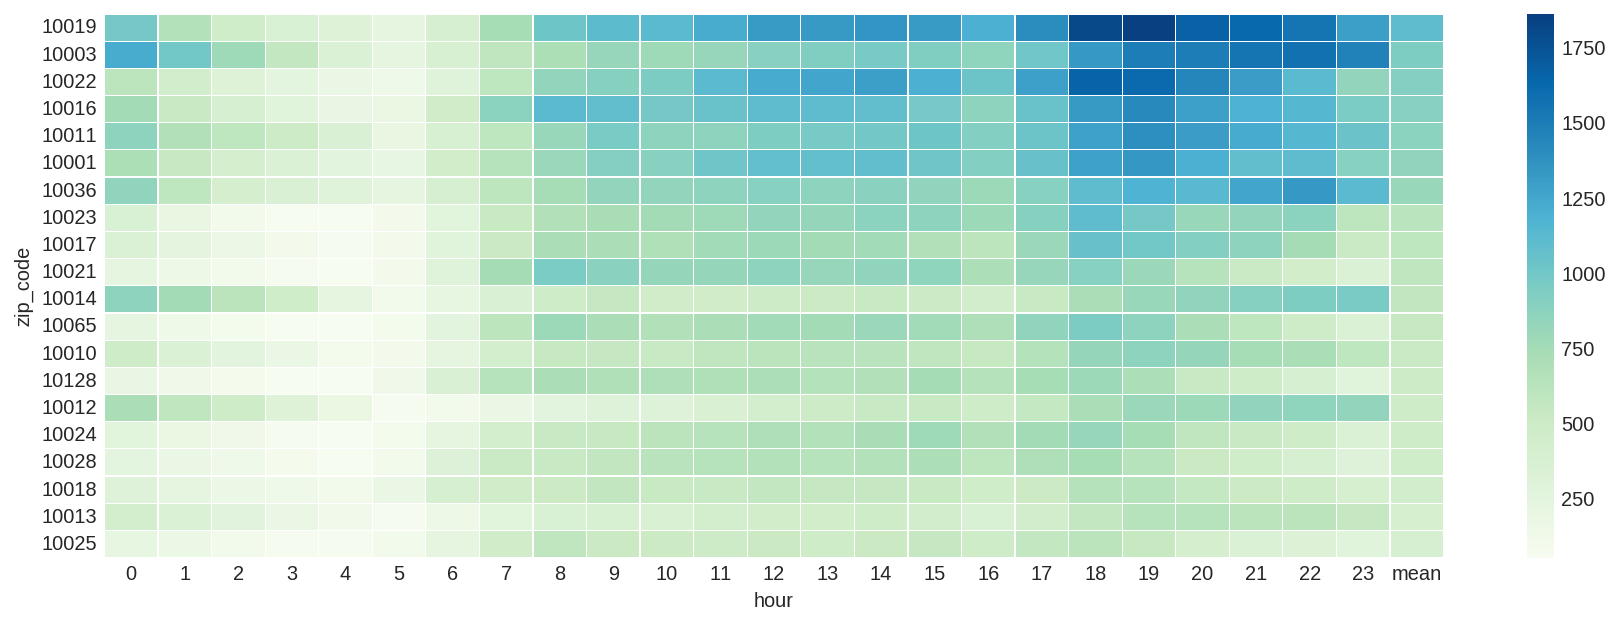

In [ ]:
# 상위 20개 지역 추출
plt.figure(figsize=(15,5))
sns.heatmap(df_hour_zip.head(20), lw=.1, cmap='GnBu');

# 데이터 전처리

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

PROJECT_ID='geultto' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

In [ ]:
%%time
extract_query = """
SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday, 
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
    WHERE EXTRACT(MONTH from pickup_datetime) = 1
    GROUP BY pickup_hour
)
ORDER BY pickup_hour
"""
PROJECT_ID = 'newyorktaxi-340407'

df = pd.read_gbq(query=extract_query, dialect='standard', project_id=PROJECT_ID)

CPU times: user 84.2 ms, sys: 1.15 ms, total: 85.3 ms
Wall time: 2.62 s


In [ ]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


In [ ]:
df['month'] = df['pickup_hour'].dt.month
df['day'] = df['pickup_hour'].dt.day
df['weekday'] = df['pickup_hour'].dt.weekday
df['hour'] = df['pickup_hour'].dt.hour
df['is_weekend'] = (df['pickup_hour'].dt.weekday // 5 == 1).astype(int)

In [ ]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


## 전처리 : 좌표를 zip_code로 변환하기

In [ ]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

CPU times: user 3.82 s, sys: 240 ms, total: 4.06 s
Wall time: 18.5 s


In [ ]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
87015,11378,2015-01-31 23:00:00,1,31,5,23,1,1
87016,10169,2015-01-31 23:00:00,1,31,5,23,1,2
87017,10034,2015-01-31 23:00:00,1,31,5,23,1,5
87018,11228,2015-01-31 23:00:00,1,31,5,23,1,1
87019,11375,2015-01-31 23:00:00,1,31,5,23,1,2


## One-hot encoding

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])

OneHotEncoder(handle_unknown='ignore')

In [ ]:
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
oh_feature_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
oh_feature_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10065,2015-01-01,1,1,3,0,0,745,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11373,2015-01-01,1,1,3,0,0,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11213,2015-01-01,1,1,3,0,0,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 데이터셋 분리
- 시계열 데이터이므로 random sampling인 아닌 과거놔 미래 데이터를 순서대로 나눠야 한다.

In [ ]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [ ]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : train/test 기준 일
    """
    criteria = (max(df['pickup_hour']) - pd.Timedelta(days=period)).date()
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

In [ ]:
train_df, test_df = split_train_and_test(oh_feature_df, '2015-01-24')

In [ ]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10065,2015-01-01,1,1,3,0,0,745,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11373,2015-01-01,1,1,3,0,0,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11213,2015-01-01,1,1,3,0,0,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10024,2015-01-01,1,1,3,0,0,869,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11237,2015-01-01,1,1,3,0,0,38,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [ ]:
y_train = train_df.pop('cnt')
x_train = train_df.copy()

In [ ]:
y_test = test_df.pop('cnt')
x_test = test_df.copy()

In [ ]:
x_train.head(5)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.head(5)

0    745
1     14
2      4
3    869
4     38
Name: cnt, dtype: int64

# 베이스라인 모델 구축

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='newyorktaxi-340407' 

In [ ]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

CPU times: user 3.67 s, sys: 72.3 ms, total: 3.74 s
Wall time: 7.64 s


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

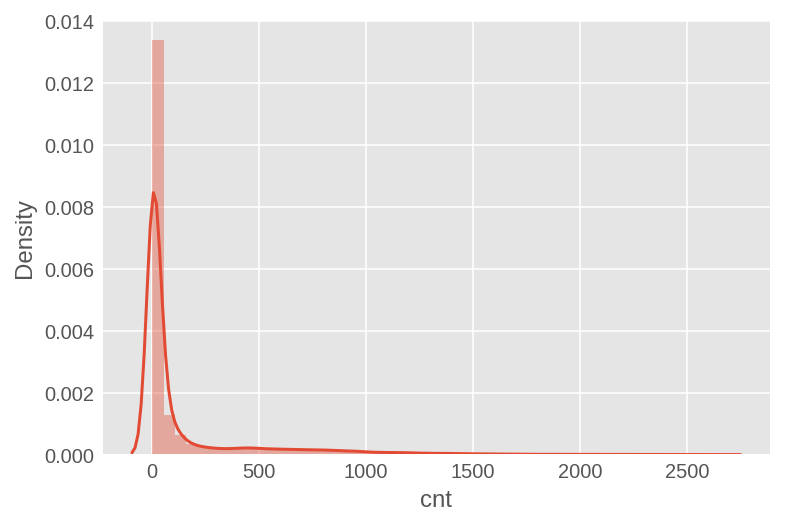

In [ ]:
# 전체 분포
sns.distplot(base_df['cnt']);

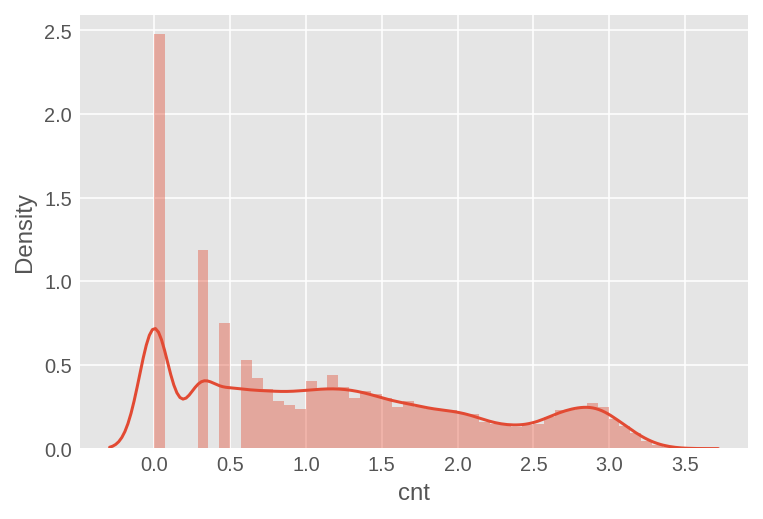

In [ ]:
# 전체 분포 log화
sns.distplot(np.log10(base_df['cnt']));

In [ ]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

## Train/Test 나누기

In [ ]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [ ]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [ ]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [ ]:
x_train = train_df.copy()
x_test = test_df.copy()

# Simple Regression

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([0.60909412, 1.50726922, 1.49864122, ..., 1.85975289, 0.82956935,
       0.7027377 ])

In [ ]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [ ]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [ ]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


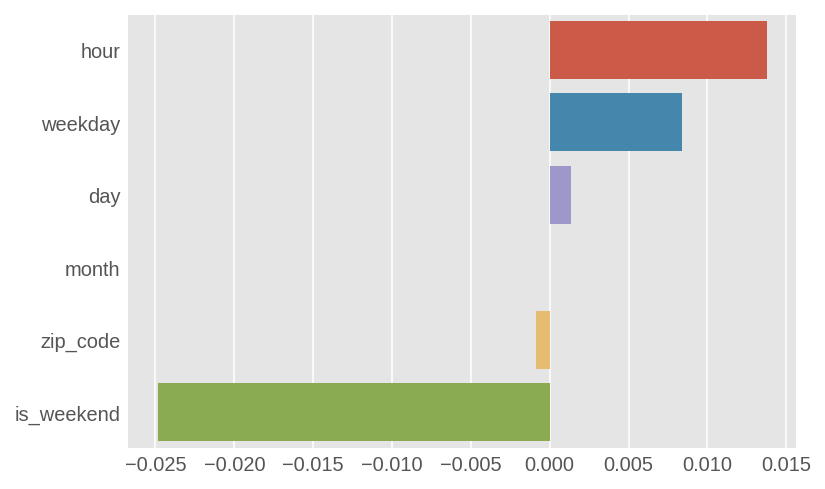

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

# One Hot Encoding

In [ ]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.20237732, 2.44728088, 2.18490601, ..., 0.46644592, 0.23516846,
       0.69596863])

In [ ]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [ ]:
# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [ ]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.89506,67.012462,27048.809736


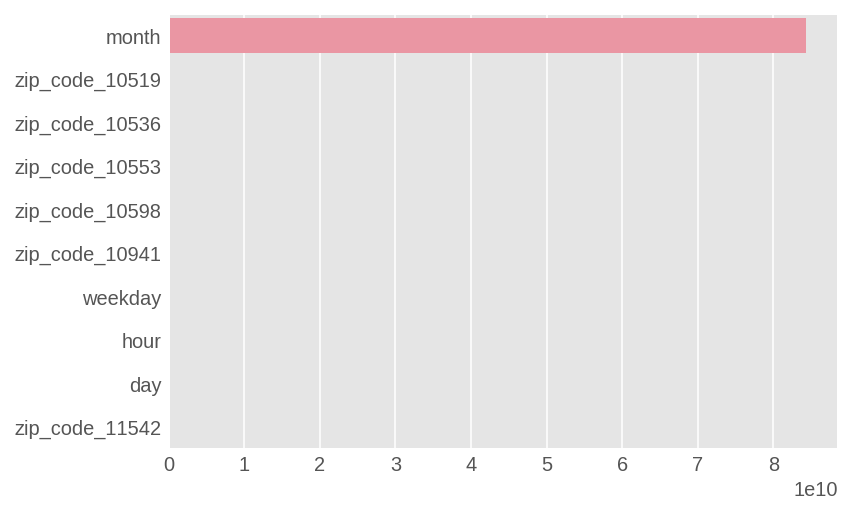

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

# XGBoost Regressor

In [ ]:
!pip install sacred

     |████████████████████████████████| 106 kB 6.4 MB/s 
     |████████████████████████████████| 99 kB 6.6 MB/s 
     |████████████████████████████████| 181 kB 13.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=e27131f24df308f9259e8a1ea089446c7237491a91e8d01fdb828aa25148a226
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from xgboost import XGBRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='newyorktaxi-340407' 

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])

In [ ]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

INFO - pandas_gbq.gbq -   Elapsed 7.1 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 8.22 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 9.34 s. Waiting...
INFO - pandas_gbq.gbq -   Elapsed 10.45 s. Waiting...
INFO - pandas_gbq.gbq - Total time taken 18.66 s.
Finished at 2022-03-18 11:59:24.


CPU times: user 4.34 s, sys: 142 ms, total: 4.48 s
Wall time: 18.7 s


In [ ]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [ ]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [ ]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [ ]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [ ]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,97,204
1,1,1,3,0,0,15,80


In [ ]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [ ]:
x_train = train_df.copy()
x_test = test_df.copy()

In [ ]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [ ]:
@ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [ ]:
@ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [ ]:
@ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [ ]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "1"


[12:00:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO - nyc-demand-prediction - Result: {'mape': {'score': 538.5201729610042}, 'mae': {'score': 57.678736192127054}, 'mse': {'score': 16512.330210514276}}
INFO - nyc-demand-prediction - Completed after 0:00:03


In [ ]:
experiment_result.config

{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 941868452}

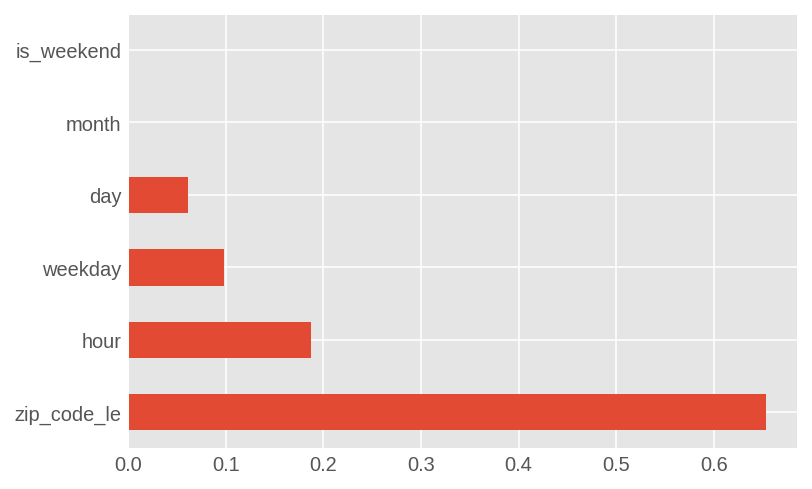

In [ ]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

# LightGBM Regressor

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from lightgbm import LGBMRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [ ]:
@ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [ ]:
@ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [ ]:
@ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    score = evaluation(y_test_raw, lgbm_pred)
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [ ]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "3"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 421.6856972338653}, 'mae': {'score': 48.24149103960721}, 'mse': {'score': 13755.684889975497}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [ ]:
experiment_result.config

{'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 128203684}

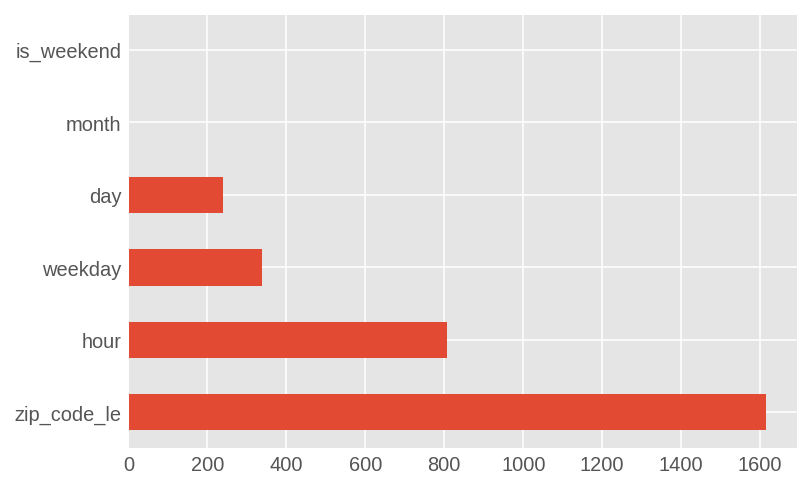

In [ ]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

# 테스트 데이터

In [ ]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = lgbm_pred

In [ ]:
test_df['year'] = 2015

In [ ]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

In [ ]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [ ]:
test_df = test_df.set_index('datetime')

# 결과 분석 
## Datetime별 차이

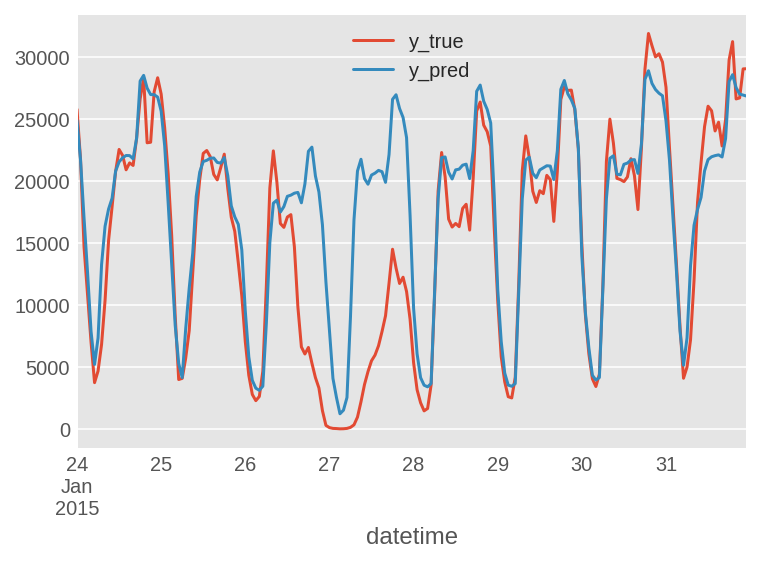

In [ ]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

## Hour별 차이

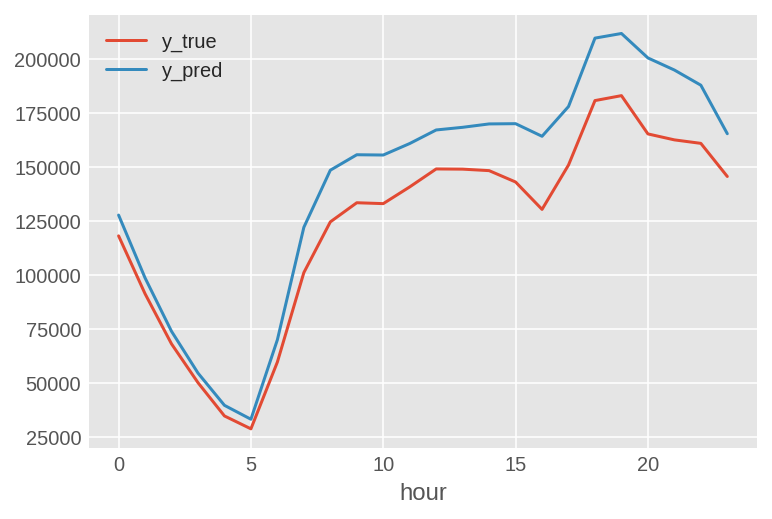

In [ ]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

In [ ]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']]

,y_true,y_pred
hour,,
0,118017,127643.050266
1,91196,98540.950898
2,67973,73801.742572
3,50021,54463.070994
4,34603,39522.069553
5,28638,33077.213224
6,59575,69884.953064
7,100996,121968.110840
8,124475,148412.869329


## 요일별 차이

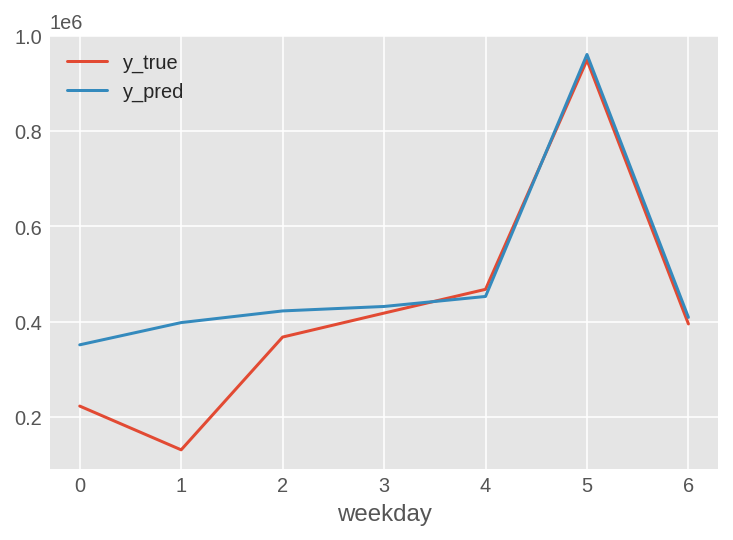

In [ ]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

## 평일/주말 분석

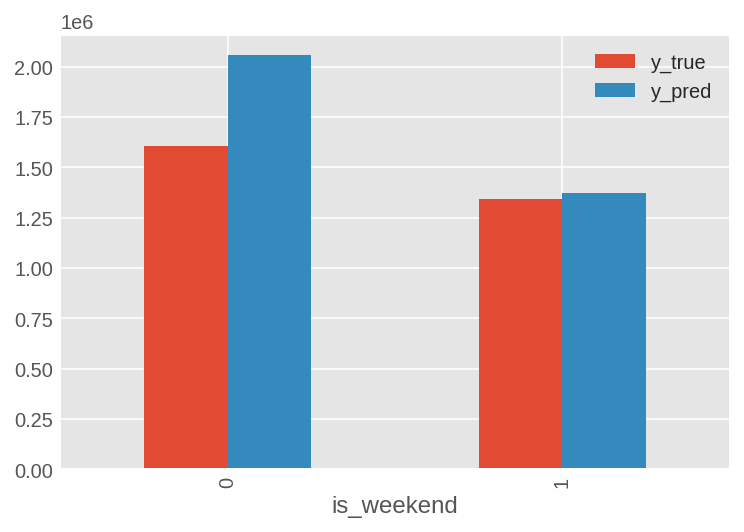

In [ ]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');